# Draft for HW 5
Progress:
1. Eigenvalues and Power Iterations
    * ~~(a) done~~
    * (b) 
        * Need to compare as a function of iterations
        * make plots
    * (c)
        * **Better way to find the initial guesses???**
        * make plots to compare accuracy
    * (d) 
        * **I THINK I NEED TO ORTHOGONALIZE FIRST?**
        * compare as function
        * make b plots
        * make c plots


2. Yale Faces
    * ~~CHECK CORRELATION MATRIX IS RIGHT~~
    * ~~(a) done~~
    * (b) **haven't started**
    * (c) **haven't started**
    

In [2]:
import cv2 
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import linalg
import scipy


Note that the data for the Yale faces datasets can be found on the course website in the "Homework + Data + Text" section: https://faculty.washington.edu/kutz/am584/am584.html. 
        

In [3]:
main_dir = '/Users/jmnugent/Documents/__Year_3_2020-2021/AMATH_584-Numerical_Linear_Algebra/Homework/python/'

crop_dir = main_dir + 'CroppedYale/'
uncrop_dir = main_dir + 'yalefaces_uncropped/yalefaces/'
save_dir = main_dir + 'amath584/hw5_iterative_methods/'


## Define Functions

In [960]:
def power_iteration(A, v0=None, tol=1e-6, num_iter=None, stop=1e6):
    """
    Performs power iteration on input matrix A (m x m) until the
    gradient of the Rayleigh quotient is less than or equal to the
    tol (default: 1e-6). If num_iter is given, will perform a set 
    number of iterations (and not necessarily go until the tolerance is reached).
    
    Assumes A is square. The initial guess is a randomized vector of unit length if
    not given (v0).
    
    Returns the list of eigenvalue and corresponding eigenvector iterations. 
    If num_iter=None, returns only the largest eigenvalue/vector and how many iterations it took to
    reach the tolerance.

    Stops after 'stop' iterations to prevent an infinite loop.
    """
    # functions for the Rayleigh quotient and its gradient
    r = lambda x: (x.T @ A @ x) / (x.T @ x)
    gradr = lambda x: (2 / (x.T @ x)) * ((A @ x) - (r(x)*x))
    
    # get size m
    m = A.shape[0]

    # iterate some number of times
    if num_iter is not None:
        if type(num_iter) != int:
            raise Exception('Invalid input for num_iter! Must be an integer # of iterations.')
        else:
            # initialize
            lk = np.zeros(num_iter, dtype=complex)
            vk = np.zeros((num_iter, m, 1), dtype=complex)
            
            if v0 is None:
                v0 = np.random.randn(m, 1)
            v0 = v0 / np.linalg.norm(v0)
            vk[0, :] = v0
            lk[0] = v0.T @ A @ v0
            
            # iterate
            for k in range(num_iter-1):
                w = A @ vk[k, :]
                vk[k+1, :] = w / np.linalg.norm(w)
                lk[k+1] = vk[k+1, :].T @ A @ vk[k+1, :]

            # lk[-1], vk[-1, :] will give you the largest
            return [lk, vk]
    
    # iterate until you reach some value
    else: 
        # initialize
        n = 0
        if v0 is None:
            vk = v0
        vk = np.random.randn(m, 1)
        vk = vk / np.linalg.norm(vk)
        lk = vk.T @ A @ vk
        
        # iterate
        while np.any(np.abs(gradr(vk)) > tol):
            if n > stop:
                print('STOPPED AFTER ' + str(int(stop)) + ' ITERATIONS')
                return [lk[0][0], vk, n]
                break
            n += 1
            w = A @ vk
            vk = w / np.linalg.norm(w)
            lk = vk.T @ A @ vk
        
        # lk[0][0] will give you the largest
        return [lk, vk, n]
    
    

In [1054]:
def rq_iteration(A, v0, tol=1e-6, num_iter=None, stop=1e6):
    """
    Performs Rayleigh Quotient iteration on input matrix A (m x m)
    for some initial guess of eigenvector v0 (m x 1) until the difference
    between lambda(k-1) and lambda(k) < tol. If num_iter is given, will
    perform a set number of iterations (and not necessarily go until the
    tolerance is reached).
    
    Assumes A is square.
    
    Returns the list of eigenvalue and corresponding eigenvector iterations. 
    If num_iter=None, returns only the largest eigenvalue/vector and how many iterations it took to
    reach the tolerance.
    
    Stops after 'stop' iterations to prevent an infinite loop.
    """
    # functions for the Rayleigh quotient and its gradient
    r = lambda x: (x.T @ A @ x) / (x.T @ x)
    gradr = lambda x: (2 / (x.T @ x)) * ((A @ x) - (r(x)*x))
    
    # get size m
    m = A.shape[0]
    
    # initialize arrays
    eigs = np.zeros(m, dtype=complex)
    vecs = np.zeros((m, m), dtype=complex)

    # iterate some number of times
    if num_iter is not None:
        if type(num_iter) != int:
            raise Exception('Invalid input for num_iter! Must be an integer # of iterations.')
        else:
            # initialize
            lk = np.zeros(num_iter, dtype=complex)
            vk = np.zeros((num_iter, m, 1), dtype=complex)
            vk[0, :] = v0
            lk[0] = v0.T @ A @ v0
            
            # iterate
            for k in range(num_iter-1):
                try:
                    w = np.linalg.solve((A - lk[k]*np.eye(m)), vk[k, :])
                except:
                    return [lk[:k], vk[:k]]
                vk[k+1, :] = w / np.linalg.norm(w)
                lk[k+1] = vk[k+1, :].T @ A @ vk[k+1, :]
                
            # lk[-1], vk[-1, :] will give you the largest
            return [lk, vk]

    # iterate until the difference is very small
    else:
        # initialize
        l0 = v0.T @ A @ v0

        # first iteration
        n = 1
        w = np.linalg.solve((A - l0*np.eye(m)), v0)
        vk = w / np.linalg.norm(w)
        lk = vk.T @ A @ vk

        # iterate until lambdas are equal within the tolerance
        lk_prev = l0
        while np.abs(lk - lk_prev) > tol:
            n += 1
            if n > stop:
                print('STOPPED AFTER ' + str(int(stop)) + ' ITERATIONS')
                return [lk[0][0], vk, n]
                break
            lk_prev = lk
            try:
                w = np.linalg.solve((A - lk*np.eye(m)), vk)
            except:
                return [lk[0][0], vk, n]
                break
            vk = w / np.linalg.norm(w)
            lk = vk.T @ A @ vk            

        return [lk[0][0], vk, n]
    

In [787]:
def rand_unitvec(m, c=False):
    """Generate a random mx1 vector of unit length. Complex if c=True.
    """
    if c:
        v = np.random.randn(m, 1) + np.random.randn(m, 1)*1j
    else:
        v = np.random.randn(m, 1)
    v1 = v / np.linalg.norm(v)
    
    return v1


# 1. Eigenvalues and Power Iterations

## part (a)
Generate a random, symmetric matrix A which is mxm where m=10. Use the EIGS command (**scipy.linalg.eig**) to give you the _ground truth_ eigenvalues and eigenvectors

Used suggestion from here to make the random matrix symmetric: https://stackoverflow.com/questions/10806790/generating-symmetric-matrices-in-numpy

In [492]:
# build the matrix
m = 10
A_nonsymm = np.random.randn(m, m)
A = np.tril(A_nonsymm) + np.tril(A_nonsymm, -1).T

# check symmetric
print(np.all(A == A.T))

# ground truth
eigvals, eigvecs = scipy.linalg.eig(A)


True


In [493]:
print(eigvals)

[ 5.14527394+0.j  3.78710983+0.j -4.87921141+0.j -4.48810034+0.j
 -3.09717203+0.j -2.09103977+0.j -0.73393744+0.j  1.90720568+0.j
  1.03512185+0.j  0.85169335+0.j]


## part (b)
Find the largest eigenvalue with the **power iteration** method. Compare the accuracy of the method as a function of iterations.

In [494]:
# function to find gradient of the rayleigh quotient
r = lambda x: (x.T @ A @ x) / (x.T @ x)
gradr = lambda x: (2 / (x.T @ x)) * ((A @ x) - (r(x)*x))
   
# to check for accuracy, this should be true
tol = 1e-6
is_close = lambda x: np.all(np.abs(gradr(x)) < tol)


### Make plots

"Find the largest eigenvalue with the **power iteration** method. Compare the accuracy of the method as a function of iterations." (_What happens to v(k) as k gets big? What is v converging to?_)

In [495]:
# try 300 iterations
k = 300
l_list, v_list = power_iteration(A, num_iter=k)
print(l_list[-1])
print(is_close(v_list[-1, :]))
print(k, 'iterations')

# for comparison, see how many iterations it takes to converge
l_conv, v_conv, n_conv = power_iteration(A, tol=tol)
print('\n', l_conv)
print(is_close(v_conv))
print(n_conv, 'iterations')


(5.145273940499408+0j)
False
300 iterations

 [[5.14527394]]
True
250 iterations


/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


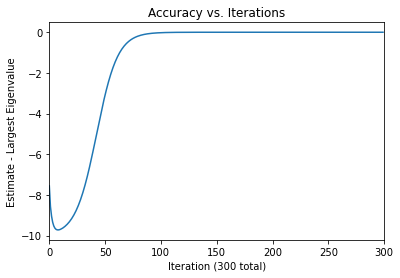

In [971]:
plt.plot(np.arange(k), [x-eigvals[0] for x in l_list])

plt.title('Accuracy vs. Iterations')
plt.ylabel('Estimate - Largest Eigenvalue')
plt.xlabel('Iteration ({} total)'.format(k))
plt.xlim((0, k))


plt.savefig(save_dir + '1b_accuracy_vs_iterations.png', dpi=300, bbox_inches='tight')

plt.show()


## part (c)

Find all 10 eigenvalues by **Rayleigh Quotient** iteration and guessing initial "eigenvectors." Compare the accuracy of the method as a function of iterations and discuss your initial guesses to find all eigenvalue/eigenvector pairs.

##### ...actually guess...?

##### Loop to get all 10 unique values
NOTE: this only works as written for symmetric matrices A because you know the eigenvalues are unique!

In [1162]:
def plot_accuracy(l_list, k, n, eigvals=eigvals, save_dir=save_dir, save=False):
    """Make the plot for each eigenvector
    """
    truth = eigvals[np.abs(l_list[-1]-eigvals).argmin()]
    
    plt.plot(np.arange(len(l_list)), [x-truth for x in l_list])

    plt.title('Accuracy vs. Iterations\n(eigenvalue = {})'.format(truth.real))
    plt.ylabel('Estimate - Actual')
    plt.xlabel('Iteration ({} total)'.format(k))
    plt.xlim((0, k))

    if save:
        plt.savefig(save_dir + '1b_accuracy_vs_iterations_eigval_{}.png'.format(n), dpi=300, bbox_inches='tight')
    
    plt.show()


/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


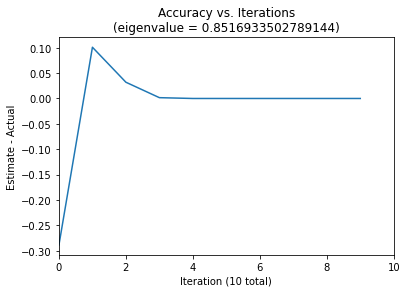

<ipython-input-1163-de27f1427768>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs_rq[0] = eigs_rq0[-1]
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


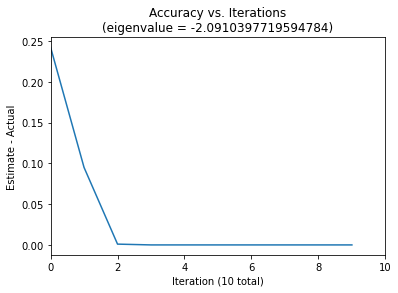

<ipython-input-1163-de27f1427768>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.round(eig, 6) not in np.round(eigs_rq, 6):
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


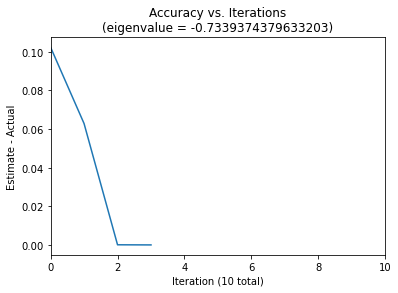

<ipython-input-1163-de27f1427768>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.round(eig, 6) not in np.round(eigs_rq, 6):
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


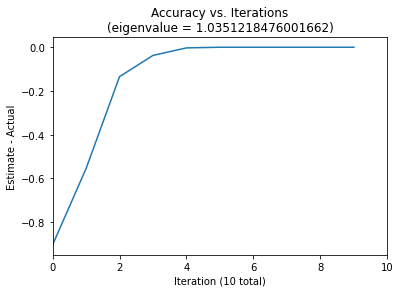

<ipython-input-1163-de27f1427768>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.round(eig, 6) not in np.round(eigs_rq, 6):
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


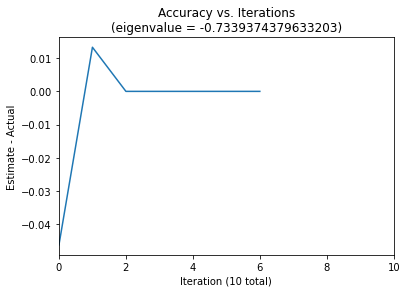

<ipython-input-1163-de27f1427768>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.round(eig, 6) not in np.round(eigs_rq, 6):
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


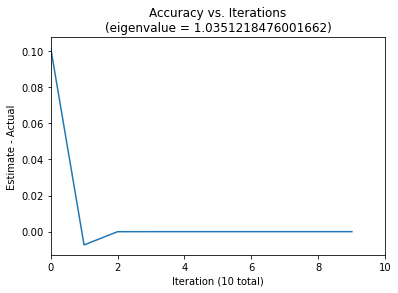

<ipython-input-1163-de27f1427768>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.round(eig, 6) not in np.round(eigs_rq, 6):
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


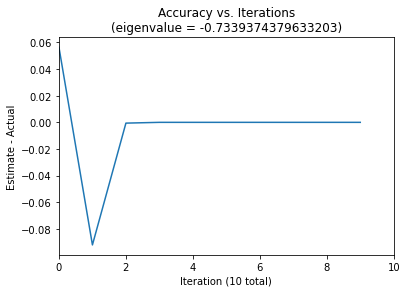

<ipython-input-1163-de27f1427768>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.round(eig, 6) not in np.round(eigs_rq, 6):
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


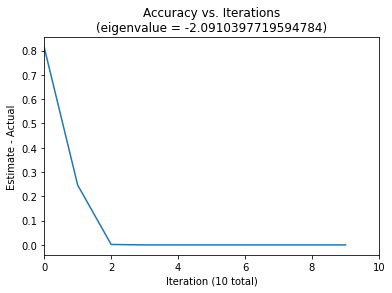

<ipython-input-1163-de27f1427768>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.round(eig, 6) not in np.round(eigs_rq, 6):
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


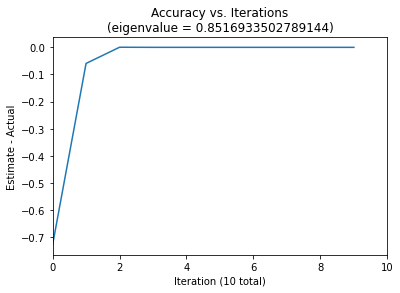

<ipython-input-1163-de27f1427768>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.round(eig, 6) not in np.round(eigs_rq, 6):
/anaconda2/envs/climate_tool/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


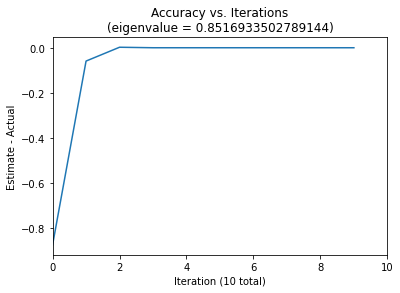

In [1163]:
k_rq = 10

# initialize list of eigenvalues with an array because it
# gets returned as a float
eigs_rq = np.zeros(1)

# perform one iteration to find an eigenvalue/eigenvector pair
eigs_rq0, vecs_rq = rq_iteration(A, rand_unitvec(m), num_iter=k_rq)
plot_accuracy(eigs_rq0, k=k_rq, n=0, save=True)
eigs_rq[0] = eigs_rq0[-1]

# repeat the iteration until you find all 10 unique ones;
# check for uniqueness to 6 decimal points (because tol=1e-6)
while len(eigs_rq) < 10:
    eig, vecs = rq_iteration(A, rand_unitvec(m), num_iter=k_rq)
    if np.round(eig, 6) not in np.round(eigs_rq, 6):
        plot_accuracy(eig, k=k_rq, n=len(eigs_rq), save=True)
        eigs_rq = np.append(eigs_rq, eig[-1])


##### quick check that you got all 10!

In [1091]:
print('From Rayleigh Quotient iteration:')
# print(sorted(eigs_rq, key=abs)[::-1])
for x in eigs_rq: print(x)

print('\nGround truth:')
for x in eigvals: print(x)


From Rayleigh Quotient iteration:
(-2.0910397719594767+0j)
(1.0351218476001665+0j)
(1.0351218476001665+0j)
(-0.7339368092514114+0j)
(-2.0910397719594767+0j)
(-0.7339374379633269+0j)
(-3.0971720317371+0j)
(-2.0910397719594767+0j)
(-0.7339396515418078+0j)
(1.9072056845573768+0j)

Ground truth:
(5.145273940514015+0j)
(3.7871098289895264+0j)
(-4.8792114140494105+0j)
(-4.488100336832757+0j)
(-3.0971720319186646+0j)
(-2.0910397719594784+0j)
(-0.7339374379633203+0j)
(1.9072056845573797+0j)
(1.0351218476001662+0j)
(0.8516933502789144+0j)


## part (d)
Repeat (b) and (c) with a **random matrix** that is not symmetric. Be sure to plot the eigenvalue in the complex plane.

In [841]:
# build the matrix
m = 10

# first guess
A_ns = np.random.randn(m, m)
eigvals_ns, eigvecs_ns = scipy.linalg.eig(A_ns)

# if the convergence ratio is very large, try again
while np.abs(eigvals_ns[1]/eigvals_ns[0]) > 0.98:
    A_ns = np.random.randn(m, m)
    eigvals_ns, eigvecs_ns = scipy.linalg.eig(A_ns)

# ground truth
print(eigvals_ns[0])


(3.137418526663922+0j)


In [962]:
eigvals_ns

array([ 3.13741853+0.j        , -0.99443654+2.20235467j,
       -0.99443654-2.20235467j,  0.67543979+1.83084164j,
        0.67543979-1.83084164j,  1.27592034+0.j        ,
       -2.66566678+0.j        , -1.33707788+0.45863589j,
       -1.33707788-0.45863589j, -0.61570809+0.j        ])

#### part (b), non-symmetric

In [842]:
# function to find gradient of the rayleigh quotient
r = lambda x: (x.T @ A_ns @ x) / (x.T @ x)
gradr = lambda x: (2 / (x.T @ x)) * ((A_ns @ x) - (r(x)*x))

# to check for accuracy, this should be true
tol = 1e-6
is_close = lambda x: np.all(np.abs(gradr(x)) < tol)


In [956]:
# initial complex
v0c = rand_unitvec(m, c=True)

In [968]:
# k2 iterations
k2 = 150
lpi_ns, vpi_ns = power_iteration(A_ns, v0=v0c, num_iter=k2)
print(k2, 'iterations')
print(lpi_ns[-1])
print(is_close(vpi_ns[-1, :]), '\n')

# unit it converges
lpi_ns2, vpi_ns2, npi_ns2 = power_iteration(A_ns, v0=v0c)
print(npi_ns2, 'iterations')
print(lpi_ns2)


150 iterations
(-3.1334965752813564+0.1568254560901839j)
True 

95 iterations
[[3.13741837]]


#### Plot the accuracy vs. number of iterations

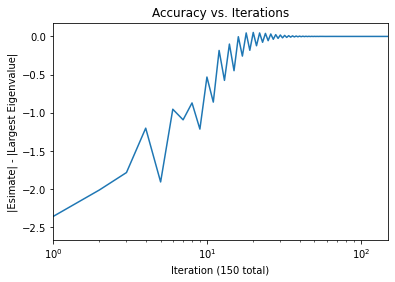

In [975]:
plt.plot(np.arange(k2), [np.abs(x)-np.abs(eigvals_ns[0]) for x in lpi_ns])

plt.xscale('log')
plt.title('Accuracy vs. Iterations')
plt.ylabel('|Esimate| - |Largest Eigenvalue|')
plt.xlabel('Iteration ({} total)'.format(k2))
plt.xlim((1, k2))

plt.savefig(save_dir + '1d_b_accuracy_vs_iterations.png', dpi=300, bbox_inches='tight')

plt.show()


#### part (c), non-symmetric

In [1160]:
def plot_accuracy_ns(l_list, k, n, eigvals=eigvals_ns, save_dir=save_dir, save=False):
    """Make the plot for each eigenvector
    """
    truth = eigvals[np.abs(np.abs(l_list[-1])-[np.abs(x) for x in eigvals]).argmin()]
    
    plt.plot(np.arange(len(l_list)), [np.abs(x)-np.abs(truth) for x in l_list])

    plt.title('Accuracy vs. Iterations')
    plt.ylabel('|Estimate| - |Actual|')
    plt.xlabel('Iteration ({} total)'.format(k))
    plt.xscale('log')
    plt.xlim((1, k))

    if save:
        plt.savefig(save_dir + '1dc_accuracy_vs_iterations_eigval_{}.png'.format(n), dpi=300, bbox_inches='tight')
    
    plt.show()


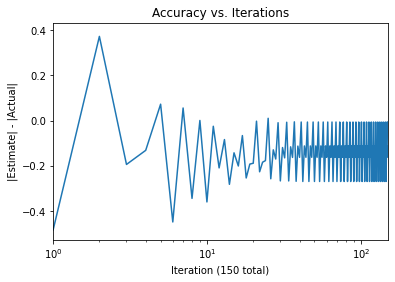

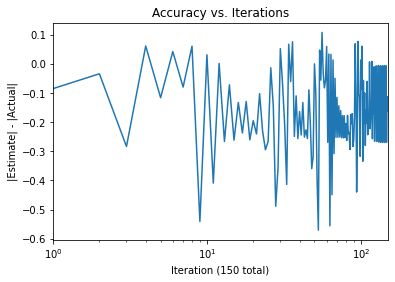

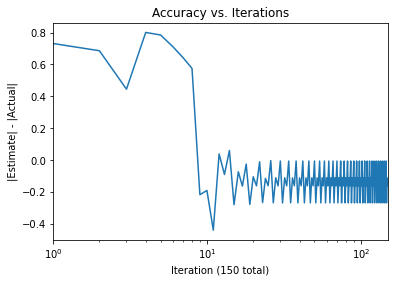

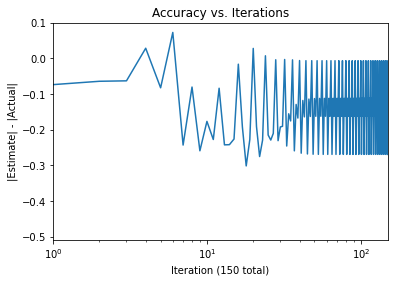

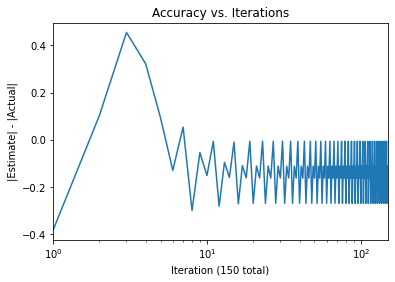

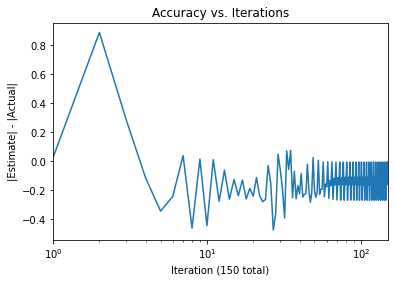

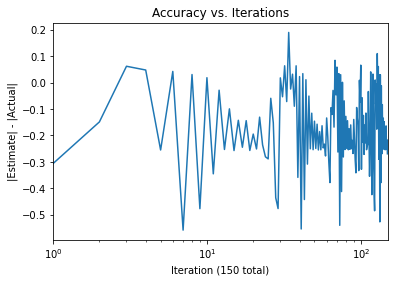

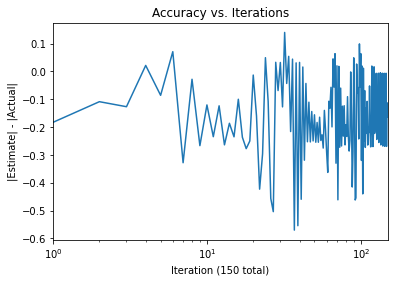

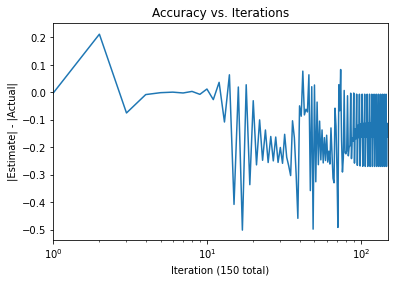

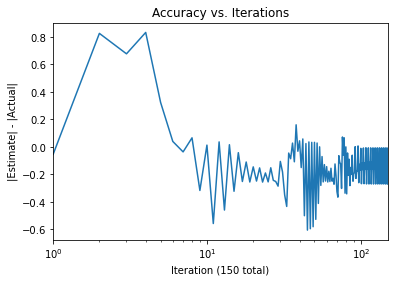

In [1161]:
k_rq_ns = 150

# initialize list of eigenvalues 
eigs_rq_ns = np.zeros(1, dtype=complex)

# perform one iteration to find an eigenvalue/eigenvector pair
eigs_rq_ns0, vecs_rq = rq_iteration(A_ns, rand_unitvec(m, c=True), num_iter=k_rq_ns)
plot_accuracy_ns(eigs_rq_ns0, k=k_rq_ns, n=0, save=False)
eigs_rq_ns[0] = eigs_rq_ns0[-1]

# repeat the iteration until you find all 10 unique ones;
# check for uniqueness to 6 decimal points (becA_nsuse tol=1e-6)
while len(eigs_rq_ns) < 10:
    eig, vecs = rq_iteration(A_ns, rand_unitvec(m, c=True), num_iter=k_rq_ns)
    eig_rounded = np.round(eig[-1].real, 6) + np.round(eig[-1].imag, 6)*1j
    eigs_rq_rounded = [np.round(x.real, 6) + np.round(x.imag, 6)*1j for x in eigs_rq_ns]
    if eig_rounded not in eigs_rq_rounded:
        plot_accuracy_ns(eig, k=k_rq_ns, n=len(eigs_rq_ns), save=False)
        eigs_rq_ns = np.append(eigs_rq_ns, eig[-1])


Check that you got all 10:

In [1157]:
print('From Rayleigh Quotient iteration:')
for x in eigs_rq_ns: print(x)

print('\nGround truth:')
for x in eigvals_ns: print(x)
    

From Rayleigh Quotient iteration:
(0.6056102758891122-0.06440799141589934j)
(0.6056102758897552+0.06440799141560999j)
(0.40791849513008405+0.19733181321440188j)
(0.13931213645440885-0.48379313616395214j)
(0.605460627715974-0.06471427639418956j)
(0.10175165510498829-0.3308716528660685j)
(0.10175165510498757+0.3308716528660425j)
(0.3740320174367843+0.2756934943883983j)
(0.13931213602470227+0.4837931353244014j)
(0.6418408041026207-0.11163284849794705j)

Ground truth:
(3.137418526663922+0j)
(-0.9944365352711022+2.202354674132986j)
(-0.9944365352711022-2.202354674132986j)
(0.675439789115683+1.8308416410236568j)
(0.675439789115683-1.8308416410236568j)
(1.2759203350544028+0j)
(-2.665666777198711+0j)
(-1.3370778777080297+0.4586358850162034j)
(-1.3370778777080297-0.4586358850162034j)
(-0.6157080908761007+0j)


#### Plot (in complex plane)

# 2. Yale Faces

## Read in the data:

### Cropped:

In [7]:
# get a list of paths to each subfolder in CroppedYale
paths = [crop_dir + dirname for dirname in os.listdir(crop_dir)
         if os.path.isdir(os.path.join(crop_dir, dirname))]

# initialize list to hold the averaged data matrices for each image
n_img = len(paths)
cropped_pics = [[]]*n_img
cropped_avgs = [[]]*n_img

for i in range(n_img):
    # get the list of file names within the subfolder for that image
    subfolder = paths[i] + '/'
    imagenames = [subfolder + f for f in os.listdir(subfolder)
                  if os.path.isfile(os.path.join(subfolder, f))]
    
    # make one list containing the data matrices for each (grayscale) image 
    cropped_pics[i] = [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2GRAY) for x in imagenames]

    # averaged the data matrix for this image and add to the list
    cropped_avgs[i] = np.mean(cropped_pics[i], axis=0)
    

In [8]:
# stack so each image is one column in the data matrix
all_pics_c = [cropped_pics[i][j].flatten() for i in range(len(cropped_pics))
              for j in range(len(cropped_pics[i]))]
A_yf = np.transpose(np.asarray(all_pics_c))

print(A_yf.shape)


(32256, 2432)


In [9]:
%%time
# get the square correlation matrix

C_yf = A_yf.T @ A_yf # is this right? gives 2432 x 2432

print(C_yf.shape)


(2432, 2432)
CPU times: user 2min 3s, sys: 1.85 s, total: 2min 4s
Wall time: 2min 34s


## part (a)
**Power iterate** on the matrix of images to find the dominant eigenvector and eigenvalue. Compare to the leading order SVD mode.

In [10]:
# iterate on the correlation matrix

l_data, v_data, n_data = power_iteration(C_yf)

print('took', n_data, 'iterations')


took 8 iterations
CPU times: user 689 ms, sys: 353 ms, total: 1.04 s
Wall time: 644 ms


In [11]:
# function to find gradient of the rayleigh quotient
r = lambda x: (x.T @ C_yf @ x) / (x.T @ x)
gradr = lambda x: (2 / (x.T @ x)) * ((C_yf @ x) - (r(x)*x))

# to check for accuracy, this should be true
tol = 1e-6
is_close = lambda x: np.all(np.abs(gradr(x)) < tol)


In [12]:
print(l_data)
print(gradr(v_data))
print(is_close(v_data))


309952.1007711205
[[ 8.70022632e-09]
 [ 4.54820110e-08]
 [-1.16742740e-07]
 ...
 [ 1.79170456e-09]
 [-4.54747351e-09]
 [ 3.12575139e-08]]
True


In [991]:
%%time 
# perform (economy) SVD

[Uh, Sh, VTh] = np.linalg.svd(C_yf, full_matrices=False) 


CPU times: user 8.78 s, sys: 387 ms, total: 9.17 s
Wall time: 4.86 s


In [992]:
# check that the dimensions are correct

print(C_yf.shape, Uh.shape, Sh.shape, VTh.shape)


(2432, 2432) (2432, 2432) (2432,) (2432, 2432)


#### COMPARE VALUES

In [993]:
print(Sh[0], l_data)
print(Sh[0] - l_data)


309952.10077112046 309952.1007711205
-5.820766091346741e-11


Plot the eigenvalue spectrum for the SVD and mark the eigenvalue you get from power iterations

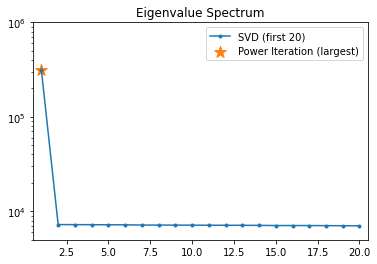

In [58]:
n_eigs = 20

plt.scatter(1, l_data, color='C1', marker='*', s=150, label='Power Iteration (largest)')
plt.plot(np.arange(1, n_eigs+1), Sh[:n_eigs], marker='.',color='C0', label='SVD (first {})'.format(n_eigs))

plt.title('Eigenvalue Spectrum')
plt.legend()
plt.yscale('log')
xmax = n_eigs + 0.5
plt.xlim((0.5, xmax))
plt.ylim((5e3, 1e6))

plt.savefig(save_dir + '2a_eigenvalue_spectra.png', dpi=300, bbox_inches='tight')

plt.show()


Plot the difference in leading eigenvectors magnitude as a bar chart... with index on x axis and value of the vector on the y axis

In [98]:
# reshape first to match the shape of Uh[:, 0]
v_data_rs = np.reshape(v_data, (len(v_data)))

# This is true if the power iteration vector & SVD vector
# have opposite signs
print(np.all(np.sign(v_data_rs) == -np.sign(Uh[:, 0])))

# find the difference in magnitude at each row
vdiff = np.abs(v_data_rs) - np.abs(Uh[:, 0])


True


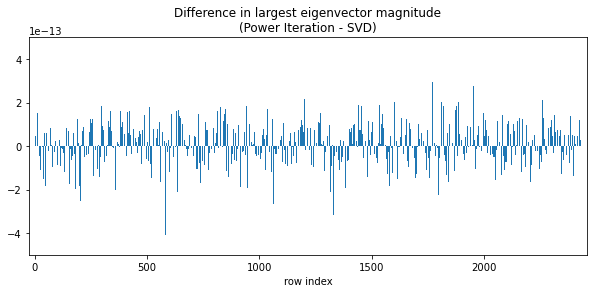

In [101]:
# plot the difference

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(np.arange(1, len(vdiff)+1), vdiff)
ax.set_title('Difference in largest eigenvector magnitude\n(Power Iteration - SVD)')
ax.set_ylim(-.5e-12, .5e-12)
ax.set_xlim(-25, len(vdiff)+25)
ax.set_xlabel('row index')

plt.savefig(save_dir + '2a_diff_in_eigenvector_mag.png', dpi=300, bbox_inches='tight')

plt.show()


## part (b)
Use **randomized sampling** to reproduce the SVD matrices: U, $\Sigma$, and V

In [994]:
def randomized_sampling(A, k, check_sizes=False):
    """
    Perform randomized sampling on matrix A. Input
    number of random projections (k)
    
    Returns Uapprox, Sapprox, and VTapprox from the 
    SVD on the randomly sampled matrix.
    """
    # --- stage A ---
    m, n = A.shape
    
    # random projections 
    omega = np.random.randn(n, k)
    Y = A @ omega
    
    # QR decomp
    Q, R = np.linalg.qr(Y, mode='reduced')
    
    # --- stage B ---
    B = Q.T @ A_yf
    Ut, St, VTt = np.linalg.svd(B, full_matrices=False)
    
    # project back out
    Uapprox = Q @ Ut

    # --- check sizes if requested ---
    if check_sizes:
        print('m, n, k:', m, n, k)
        print('Y:', Y.shape)
        print('Q:', Q.shape)
        print('B:', B.shape)
        print('U:', Uapprox.shape)
        print('S:', St.shape)
    
    return [Uapprox, St, VTt]
    
    

In [266]:
%%time
# ground truth for yale faces

U, S, VT = np.linalg.svd(A_yf, full_matrices=False)


CPU times: user 58.8 s, sys: 3.15 s, total: 1min 1s
Wall time: 37.2 s


In [995]:
# to test...

Uapprox, Sapprox, VTapprox = randomized_sampling(A_yf, k=100, check_sizes=True)

m, n, k: 32256 2432 100
Y: (32256, 100)
Q: (32256, 100)
B: (100, 2432)
U: (32256, 100)
S: (100,)


## part (c)
Compare the randomized modes to the true modes along with the singular value decay as a function of the number of randomized samples

In [996]:
# pick some ks
k_list = [5, 10, 50, 100, 1000]
Ua = [[]]*len(k_list)
Sa = [[]]*len(k_list)
VTa= [[]]*len(k_list)

# loop through each number of iterations
for i in range(len(k_list)):
    Ua[i], Sa[i], VTa[i] = randomized_sampling(A_yf, k=k_list[i])
    print('k = {} done'.format(k_list[i]))


k = 5 done
k = 10 done
k = 50 done
k = 100 done
k = 1000 done


#### Plot: eigenvalue spectra

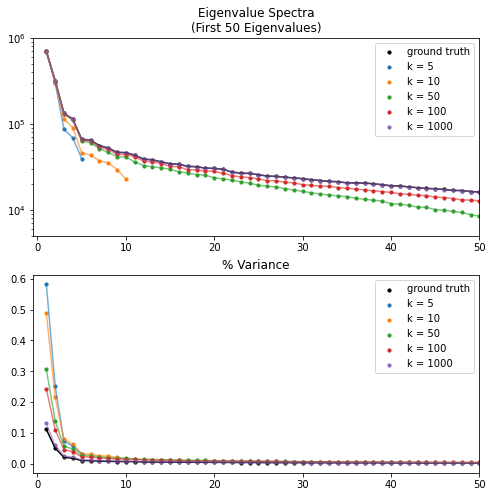

In [998]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# truth
ax1.scatter(np.arange(1, len(S)+1), S, color='k', s=10, label='ground truth')
ax1.plot(np.arange(1, len(S)+1), S, color='k')
ax2.scatter(np.arange(1, len(S)+1), S/np.sum(S), color='k', s=10, label='ground truth')
ax2.plot(np.arange(1, len(S)+1), S/np.sum(S), color='k')

# approximations
for i in range(len(k_list)):
    ax1.scatter(np.arange(1, len(Sa[i])+1), Sa[i], s=10, label='k = {}'.format(k_list[i]))
    ax1.plot(np.arange(1, len(Sa[i])+1), Sa[i], alpha=0.6)
    ax2.scatter(np.arange(1, len(Sa[i])+1), Sa[i]/np.sum(Sa[i]), s=10, label='k = {}'.format(k_list[i]))
    ax2.plot(np.arange(1, len(Sa[i])+1), Sa[i]/np.sum(Sa[i]), alpha=0.6)

ax1.set_yscale('log')
ax1.legend()
ax1.set_xlim((-.5, 50))
ax1.set_title('Eigenvalue Spectra\n(First 50 Eigenvalues)')
ax1.set_ylim((5e3, 1e6))

ax2.legend()
ax2.set_xlim((-.5, 50))
ax2.set_title('% Variance')

# plt.savefig(save_dir + '2c_eigenvalue_spectra--no_line.png', dpi=300, bbox_inches='tight')
plt.savefig(save_dir + '2c_eigenvalue_spectra--line.png', dpi=300, bbox_inches='tight')

plt.show()


#### Reconstructions


In [1010]:
# from the random sampling
A_rs_list = [[]]*len(k_list)
for i in range(len(k_list)):
    A_rs_list[i] = Ua[i] @ np.diag(Sa[i]) @ VTa[i]

# from the "true" SVD
A_rs_svd = U @ np.diag(S) @ VT


In [1024]:
x, y = cropped_pics[0][0].shape

mode0_svd = np.reshape(A_rs_svd[:, 0], (x, y))
mode1_svd = np.reshape(A_rs_svd[:, 1], (x, y))
mode2_svd = np.reshape(A_rs_svd[:, 2], (x, y))

mode0_approx_list = [[]]*len(k_list)
mode1_approx_list = [[]]*len(k_list)
mode2_approx_list = [[]]*len(k_list)

for i in range(len(k_list)):
    mode0_approx_list[i] = np.reshape(A_rs_list[i][:, 0], (x, y))
    mode1_approx_list[i] = np.reshape(A_rs_list[i][:, 1], (x, y))
    mode2_approx_list[i] = np.reshape(A_rs_list[i][:, 2], (x, y))


#### Plot: eigenface/vector reconstructions (compare randomized modes to the true modes)

Each column is a # of iterations (right = truth)

each row is a mode (show the first 3)

In [1026]:
print(k_list)

[5, 10, 50, 100, 1000]


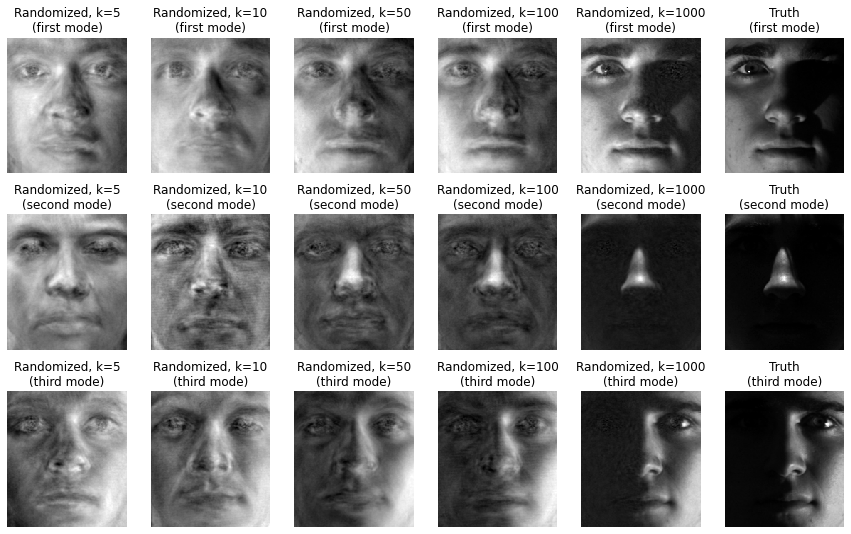

In [1043]:
fig, axes = plt.subplots(3, 6, figsize=(15, 9))
plt.subplots_adjust(hspace=0.3)

for ax in axes.flatten():
    ax.axis('off')
    
# first mode
axes[0, 0].pcolormesh(np.flip(mode0_approx_list[0]), cmap='gray')
axes[0, 0].set_title('Randomized, k=5\n(first mode)')

axes[0, 1].pcolormesh(np.flip(mode0_approx_list[1]), cmap='gray')
axes[0, 1].set_title('Randomized, k=10\n(first mode)')

axes[0, 2].pcolormesh(np.flip(mode0_approx_list[2]), cmap='gray')
axes[0, 2].set_title('Randomized, k=50\n(first mode)')

axes[0, 3].pcolormesh(np.flip(mode0_approx_list[3]), cmap='gray')
axes[0, 3].set_title('Randomized, k=100\n(first mode)')

axes[0, 4].pcolormesh(np.flip(mode0_approx_list[4]), cmap='gray')
axes[0, 4].set_title('Randomized, k=1000\n(first mode)')

axes[0, 5].pcolormesh(np.flip(mode0_svd), cmap='gray')
axes[0, 5].set_title('Truth\n(first mode)')

# second mode
axes[1, 0].pcolormesh(np.flip(mode1_approx_list[0]), cmap='gray')
axes[1, 0].set_title('Randomized, k=5\n(second mode)')

axes[1, 1].pcolormesh(np.flip(mode1_approx_list[1]), cmap='gray')
axes[1, 1].set_title('Randomized, k=10\n(second mode)')

axes[1, 2].pcolormesh(np.flip(mode1_approx_list[2]), cmap='gray')
axes[1, 2].set_title('Randomized, k=50\n(second mode)')

axes[1, 3].pcolormesh(np.flip(mode1_approx_list[3]), cmap='gray')
axes[1, 3].set_title('Randomized, k=100\n(second mode)')

axes[1, 4].pcolormesh(np.flip(mode1_approx_list[4]), cmap='gray')
axes[1, 4].set_title('Randomized, k=1000\n(second mode)')

axes[1, 5].pcolormesh(np.flip(mode1_svd), cmap='gray')
axes[1, 5].set_title('Truth\n(second mode)')

# third mode
axes[2, 0].pcolormesh(np.flip(mode2_approx_list[0]), cmap='gray')
axes[2, 0].set_title('Randomized, k=5\n(third mode)')

axes[2, 1].pcolormesh(np.flip(mode2_approx_list[1]), cmap='gray')
axes[2, 1].set_title('Randomized, k=10\n(third mode)')

axes[2, 2].pcolormesh(np.flip(mode2_approx_list[2]), cmap='gray')
axes[2, 2].set_title('Randomized, k=50\n(third mode)')

axes[2, 3].pcolormesh(np.flip(mode2_approx_list[3]), cmap='gray')
axes[2, 3].set_title('Randomized, k=100\n(third mode)')

axes[2, 4].pcolormesh(np.flip(mode2_approx_list[4]), cmap='gray')
axes[2, 4].set_title('Randomized, k=1000\n(third mode)')

axes[2, 5].pcolormesh(np.flip(mode2_svd), cmap='gray')
axes[2, 5].set_title('Truth\n(third mode)')

plt.savefig(save_dir + '2c_mode_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


# NOTES FROM LECTURE - coding

##### 11/25 lecture, 25:00-30:00

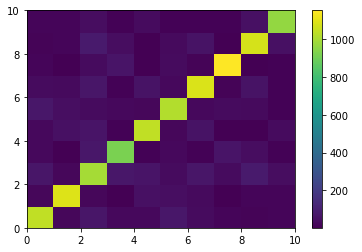

In [126]:
# make some vectors (10-dim system; play w/ # rows)

m = 1000

omega = np.random.randn(m, 10) # 10 random vectors
A_test = omega.T @ omega # inner product of all vectors against each other

plt.pcolormesh(np.abs(A_test))
plt.colorbar()

# pick 2 numbers and make random vectors out of it;
# they will be orthogonal
# will be the identity matrix if large enough

##### 11/30: 9:50-41:26

In [ ]:
# percentage of variance within the SVD modes: (plot it)
np.diag(s) / np.sum(np.diag(s))

# plot (x, U[:, 0]) where [u, s, v] = np.linalg.svd(x)
# gives you the modes! Do this for the # of columns explaining
# most of the variance (as you found out from the plot above) -
# like the first 3 or something
# if ~99% of the variance describe by the first 3, it's low-rank

# "v tells you what each modes are doing" in time... see oscillation

# "SVD is highlighting for you the features you should be 
#  looking at"



In [224]:
%%time
# the truth

# confused about which one we're supposed to do this for?
U, S, VT = np.linalg.svd(A_yf, full_matrices=False)


CPU times: user 55.4 s, sys: 2.98 s, total: 58.4 s
Wall time: 34.3 s


In [254]:
# construct a sampling matrix (random projections)
# sizes:
m, n = A_yf.shape
k = 100 # number of random projections
omega = np.random.randn(n, k) # random projection
Y = A_yf @ omega

# verify that size is right
print(Y.shape)
print(m, n, k)

(32256, 100)
32256 2432 100


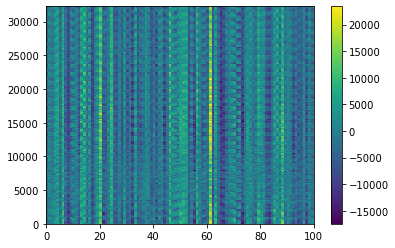

In [255]:
plt.pcolormesh(Y)
plt.colorbar()

plt.show()

In [256]:
# now do QR decomposition

Q, R = np.linalg.qr(Y, mode='reduced')


(32256, 100)


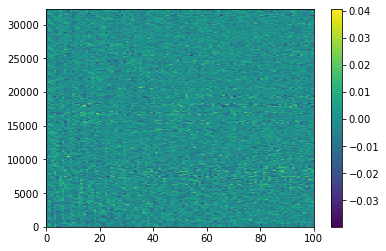

In [257]:
print(Q.shape)

plt.pcolormesh(Q)
plt.colorbar()
plt.show()


In [258]:
# project matrix A into the orthonormal column space

B = Q.T @ A_yf
print(B.shape)


(100, 2432)


In [259]:
# t for tilde

Ut, St, VTt = np.linalg.svd(B, full_matrices=False)
Uapprox = Q @ Ut


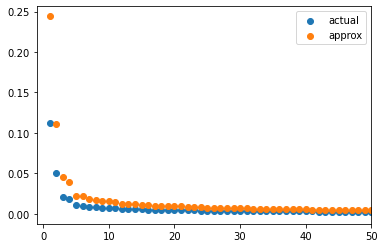

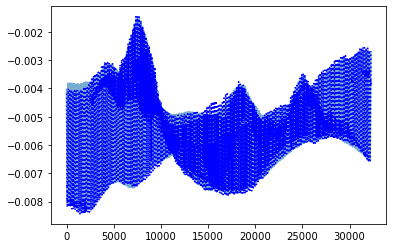

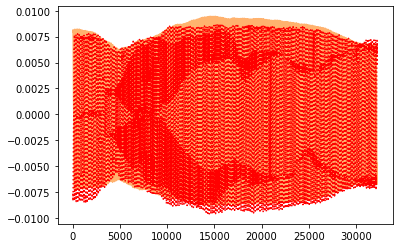

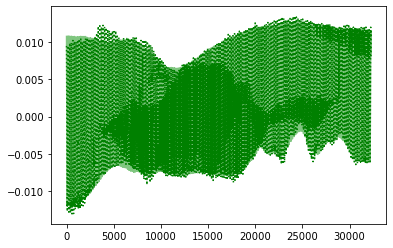

In [263]:
plt.scatter(np.arange(1, len(S)+1), S/np.sum(S), label='actual')
plt.scatter(np.arange(1, len(St)+1), St/np.sum(St), label='approx')
plt.xlim(-1, 50)
plt.legend()
plt.show()

plt.plot(U[:, 0], color='C0', label='eigenvec 1', alpha=0.6)
plt.plot(-Uapprox[:, 0], color='b', linestyle=':')
plt.show()

plt.plot(U[:, 1], color='C1', label='eigenvec 2', alpha=0.6)
plt.plot(-Uapprox[:, 1], color='r', linestyle=':')
plt.show()

plt.plot(U[:, 2], color='C2', label='eigenvec 3', alpha=0.6)
plt.plot(-Uapprox[:, 2], color='g', linestyle=':')
plt.show()


In [264]:
U0approx = np.reshape(-Uapprox[:, 0], (192, 168))
U0 = np.reshape(U[:, 0], (192, 168))

U1approx = np.reshape(-Uapprox[:, 1], (192, 168))
U1 = np.reshape(U[:, 1], (192, 168))

U2approx = np.reshape(-Uapprox[:, 2], (192, 168))
U2 = np.reshape(U[:, 2], (192, 168))


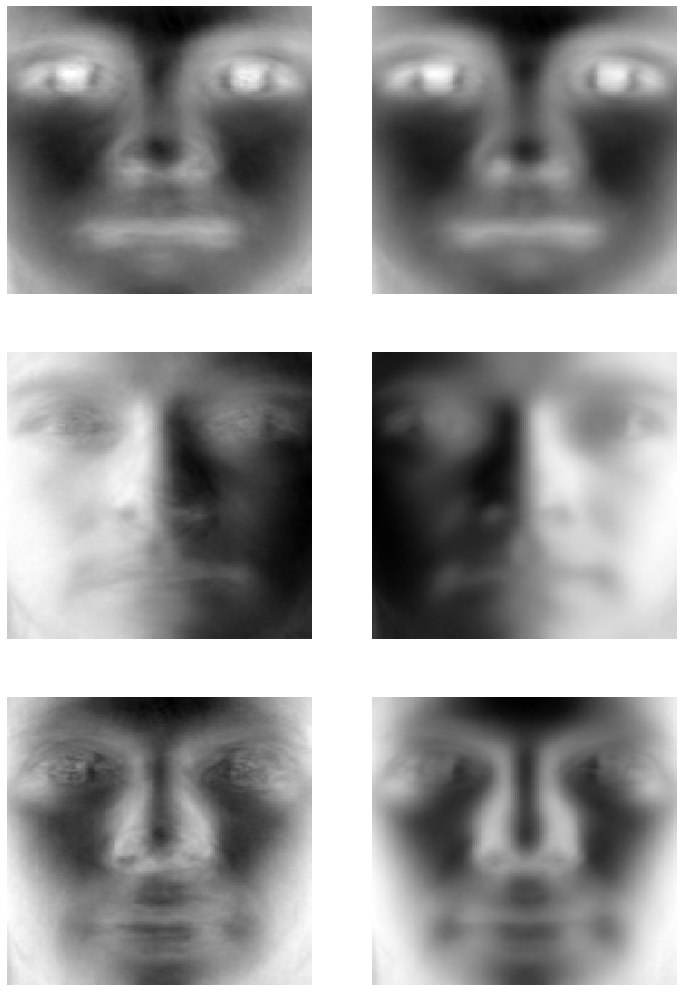

In [265]:
fig = plt.figure(figsize = (12, 18))

# first
ax0a = fig.add_subplot(321)
ax0a.pcolormesh(np.flip(U0approx), cmap='gray')
ax0a.axis('off')

ax0b = fig.add_subplot(322)
ax0b.pcolormesh(np.flip(U0), cmap='gray')
ax0b.axis('off')

# second
ax1a = fig.add_subplot(323)
ax1a.pcolormesh(np.flip(U1approx), cmap='gray')
ax1a.axis('off')

ax1b = fig.add_subplot(324)
ax1b.pcolormesh(np.flip(U1), cmap='gray')
ax1b.axis('off')

# third
ax2a = fig.add_subplot(325)
ax2a.pcolormesh(np.flip(U2approx), cmap='gray')
ax2a.axis('off')

ax2b = fig.add_subplot(326)
ax2b.pcolormesh(np.flip(U2), cmap='gray')
ax2b.axis('off')

plt.show()
